In [7]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from multiprocessing import Pool
from sys import getsizeof
from keras.utils import to_categorical
from sklearn import preprocessing 
from sklearn.preprocessing import Normalizer 

# Prepare data for training

## Read the csv file for training

In [4]:
######### Use pandas to read "bridge.csv","combats.csv" file #########


bridge_dfN = pd.read_csv('N.csv')
bridge_dfS = pd.read_csv('S.csv')  
bridge_dfE = pd.read_csv('E.csv')  
bridge_dfW = pd.read_csv('W.csv')




bridge_dfN = bridge_dfN.drop('lin_file',axis = 1)
bridge_dfN = bridge_dfN.drop('board_num',axis = 1)
bridge_dfS = bridge_dfS.drop('lin_file',axis = 1)
bridge_dfS = bridge_dfS.drop('board_num',axis = 1)
bridge_dfE = bridge_dfE.drop('lin_file',axis = 1)
bridge_dfE = bridge_dfE.drop('board_num',axis = 1)
bridge_dfW = bridge_dfW.drop('lin_file',axis = 1)
bridge_dfW = bridge_dfW.drop('board_num',axis = 1)


bridge_dfN['direction'] = 'N'
bridge_dfS['direction'] = 'S'
bridge_dfE['direction'] = 'E'
bridge_dfW['direction'] = 'W'




bridge_dfN_test = bridge_dfN[400000:405000]
bridge_dfS_test = bridge_dfS[400000:405000]
bridge_dfE_test = bridge_dfE[400000:405000]
bridge_dfW_test = bridge_dfW[400000:405000]

bridge_dfN_val = bridge_dfN[400000:420000]
bridge_dfS_val = bridge_dfS[400000:420000]
bridge_dfE_val = bridge_dfE[400000:420000]
bridge_dfW_val = bridge_dfW[400000:420000]

bridge_df_val = pd.concat([bridge_dfN_val, bridge_dfS_val], ignore_index=True)
bridge_df_val = pd.concat([bridge_df_val, bridge_dfE_val], ignore_index=True)
bridge_df_val = pd.concat([bridge_df_val, bridge_dfW_val], ignore_index=True)

bridge_dfN = bridge_dfN[:160000]
bridge_dfS = bridge_dfS[:160000]
bridge_dfE = bridge_dfE[:160000]
bridge_dfW = bridge_dfW[:160000]

bridge_df = pd.concat([bridge_dfN, bridge_dfS], ignore_index=True)
bridge_df = pd.concat([bridge_df, bridge_dfE], ignore_index=True)
bridge_df = pd.concat([bridge_df, bridge_dfW], ignore_index=True)
#bridge_df = bridge_df.astype('int')
#df = pd.read_csv('combats.csv') 
#combats_df = df
#print(combats_df.iloc[:,:])
#print(len(combats_df.iloc[:,:]))
print(len(bridge_dfN.iloc[:,:]))
print(len(bridge_dfS.iloc[:,:]))
print(len(bridge_dfE.iloc[:,:]))
print(len(bridge_dfW.iloc[:,:]))

print(len(bridge_df.iloc[:,:]))

160000
160000
160000
160000
640000


In [4]:
print(bridge_df.iloc[49998:50002])

       table_num value  self_value  op_value                      bidding_seq  \
49998          1  none           0         0  p|p|p|1C!|p|1D!|p|1S|p|4S|p|p|p   
49999          2    NS           1         0                 1H|2D|p|3N|p|p|p   
50000          2    NS           1         0   p|1C|p|1N|p|2D|p|2N|p|3N|p|p|p   
50001          3    EW           0         1              1H|2D|2N|p|4H|p|p|p   

       order suit_num sort_suit_num               suit             suits  \
49998      1  1|5|4|3       5|4|3|1  SQHQJ765DT863CQ43  Q|QJ765|T863|Q43   
49999      4  4|3|1|5       5|4|3|1  SQJ54HKJ8D4CKJ863  QJ54|KJ8|4|KJ863   
50000      4  4|3|1|5       5|4|3|1  SQJ54HKJ8D4CKJ863  QJ54|KJ8|4|KJ863   
50001      3  3|4|4|2       4|4|3|2  SQT4HJ864D9872CAQ  QT4|J864|9872|AQ   

       HCP_dis  HCP    short     void     long  winner_dis  winner  num_of_A  \
49998  2|3|0|2    7  1|0|0|0  0|0|0|0  0|1|0|0  0|2.75|1|0    3.75         0   
49999  3|4|0|4   11  0|0|1|0  0|0|0|0  0|0|0|1  1.75|

In [1]:
#print(bridge_dfW)  #set seq = 30num

train_data=[]

for i in range(len(bridge_df.iloc[:,:])):
    if bridge_df.iloc[i,1] == 'none':
        bridge_df.iloc[i,1] = 0
    elif bridge_df.iloc[i,1] == 'NS':
        bridge_df.iloc[i,1] = 1
    elif bridge_df.iloc[i,1] == 'EW':
        bridge_df.iloc[i,1] = 2
    elif bridge_df.iloc[i,1] == 'both':
        bridge_df.iloc[i,1] = 3
    split_list = bridge_df.iloc[i,4].split('|')
    temp = 0
    temp_list_bidding =[-1]*12
    for j in range(len(split_list)):
        if(j>11):
            break;
        split_list[j] = split_list[j].replace("!", "")
        if(split_list[j][0]=='p' or split_list[j][0]=='P'):
            temp_list_bidding[j]=0
            continue
        if(split_list[j][0]=='d' or split_list[j][0]=='D'):
            temp_list_bidding[j]=36
            continue
        if(split_list[j][0]=='r' or split_list[j][0]=='R'):
            temp_list_bidding[j]=37
            continue
                
                
        temp = 0
        if(len(split_list[j]) != 2):
            temp = -1
            break
        if(split_list[j][0].isdigit()):
            temp += (int(split_list[j][0])-1)*5
        if(split_list[j][1] == 'C' or split_list[j][1] == 'c'):
            temp += 1
        elif(split_list[j][1] == 'D' or split_list[j][1] == 'd' ):
            temp += 2
        elif(split_list[j][1] == 'H' or split_list[j][1] == 'h'):
            temp += 3
        elif(split_list[j][1] == 'S' or split_list[j][1] == 's'):
            temp += 4
        elif(split_list[j][1] == 'N' or split_list[j][1] == 'n'):
            temp += 5
        else:
            temp = -1
            break
        temp_list_bidding[j] = temp
        
    temp_list = []
    temp_list.append(bridge_df.iloc[i,0])
    temp_list.append(bridge_df.iloc[i,1])
    temp_list.append(bridge_df.iloc[i,2])
    temp_list.append(bridge_df.iloc[i,3])
    for j in range(12):
        temp_list.append(temp_list_bidding[j])
    temp_list.append(bridge_df.iloc[i,5])

    split_list6 = bridge_df.iloc[i,6].split('|')
    for j in range(4):
        temp_list.append(split_list6[j])
    '''
    split_list7 = bridge_df.iloc[i,7].split('|')
    for j in range(4):
        temp_list.append(split_list7[j])
    '''
    split_list9 = bridge_df.iloc[i,9].split('|')    
    for j in range(4):
        suit = [0]*13
        for k in range(len(split_list9[j])):
            if split_list9[j][k] == 'A':
                suit[1] = 1
            elif split_list9[j][k] == 'K':
                suit[0] = 1
            elif split_list9[j][k] == 'Q':
                suit[12] = 1
            elif split_list9[j][k] == 'J':
                suit[11] = 1
            elif split_list9[j][k] == 'T':
                suit[10] = 1
            elif split_list9[j][k].isdigit():
                suit[int(split_list9[j][k])] = 1
            else:
                suit[k] = -1
        temp_list = temp_list + suit
        
    split_list10 = bridge_df.iloc[i,10].split('|')
    for j in range(4):
        temp_list.append(split_list10[j])
    temp_list.append(bridge_df.iloc[i,11])
    
    split_list12 = bridge_df.iloc[i,12].split('|')
    for j in range(4):
        temp_list.append(split_list12[j])
    split_list13 = bridge_df.iloc[i,13].split('|')
    for j in range(4):
        temp_list.append(split_list13[j])
    split_list14 = bridge_df.iloc[i,14].split('|')
    for j in range(4):
        temp_list.append(split_list14[j])
    split_list15 = bridge_df.iloc[i,15].split('|')
    for j in range(4):
        temp_list.append(split_list15[j])
    
    temp_list.append(bridge_df.iloc[i,16])
    temp_list.append(bridge_df.iloc[i,17])
    if(bridge_df.iloc[i,18] == 'N'):
        temp_list.append(0)
    elif(bridge_df.iloc[i,18] == 'S'):
        temp_list.append(1)
    elif(bridge_df.iloc[i,18] == 'E'):
        temp_list.append(2)
    elif(bridge_df.iloc[i,18] == 'W'):
        temp_list.append(3)
    else:
        temp_list.append(-1)
        
    
    train_data.append(temp_list)

train_data = np.asarray(train_data)
train_data = train_data.astype('float')
print(train_data[0])
print(train_data[999])
print(train_data)
print(train_data.shape)

NameError: name 'bridge_df' is not defined

## Make the training data

In [7]:

train_data_org = train_data
train_data_backup = train_data
print(len(train_data))

320000


In [2]:
#np.savetxt('train_data_savefile_80000.txt', train_data, fmt='%f')
train_data = []
train_data = np.loadtxt('train_data_savefile_80000.txt', dtype=float)
print(train_data[0])
print(train_data[999])
print(train_data)
print(train_data.shape)

[ 1.   0.   0.   0.   0.   9.   0.   0.   0.  -1.  -1.  -1.  -1.  -1.
 -1.  -1.   1.   3.   3.   4.   3.   0.   0.   0.   0.   0.   1.   1.
  0.   0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   1.   1.   0.   0.   0.   0.   1.   0.   1.   1.   0.
  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   1.   0.   0.
  0.   0.   1.   1.   7.   2.   2.  12.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   2.5  1.   0.   3.5  1.   0. ]
[12.   1.   1.   0.   0.   5.  36.   8.   0.   0.   0.  -1.  -1.  -1.
 -1.  -1.   2.   4.   2.   4.   3.   0.   0.   1.   0.   1.   1.   0.
  0.   0.   0.   0.   1.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   1.
  1.   0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   1.   1.   6.   2.   6.  15.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   1.   1.5  1.   1.5  5.   2.   0. ]
[[ 1.   0.   0.  ...  3.5 

In [11]:

print(train_data)
train_data = preprocessing.normalize(train_data,axis = 0, norm='l2')
#normalizaer = Normalizer().fit(train_data)
#train_data = preprocessing.scale(train_data)
'''
train_data[:,0] = train_data[:,0]/50
train_data[:,1] = train_data[:,1]/3
train_data[:,4:15] = train_data[:,4:15]/37
train_data[:,16] = train_data[:,16]/4
train_data[:,17:20] = train_data[:,17:20]/13
train_data[:,73:76] = train_data[:,73:76]/13
train_data[:,81] = train_data[:,81]/30
train_data[:,91:94] = train_data[:,91:94]/10
train_data[:,95] = train_data[:,95]/10
train_data[:,96] = train_data[:,96]/10
'''
print(train_data[0,:])
print(train_data)
print(train_data.shape)
print(type(train_data))

[[8.19857000e-05 0.00000000e+00 0.00000000e+00 ... 1.16451549e-03
  1.35513547e-03 0.00000000e+00]
 [8.19857000e-05 0.00000000e+00 0.00000000e+00 ... 1.16451549e-03
  1.35513547e-03 0.00000000e+00]
 [1.63971400e-04 9.40995713e-04 2.49440943e-03 ... 8.31796778e-04
  0.00000000e+00 0.00000000e+00]
 ...
 [9.83828400e-04 9.40995713e-04 0.00000000e+00 ... 2.16267162e-03
  2.71027095e-03 2.83473355e-03]
 [9.83828400e-04 9.40995713e-04 0.00000000e+00 ... 2.16267162e-03
  2.71027095e-03 2.83473355e-03]
 [1.06581410e-03 2.82298714e-03 2.49440943e-03 ... 1.66359356e-03
  4.06540642e-03 2.83473355e-03]]
[ 8.19857000e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.00891296e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.79001171e-04 -1.70296616e-04 -1.78087762e-04
 -2.10501444e-04 -2.29380846e-04 -2.40966822e-04 -2.64292837e-04
  6.45497224e-04  1.50395912e-03  1.50331659e-03  2.00429328e-03
  1.50311392e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.000000

## Make one-hot format labels (But bridge seems to use 13-hot-encoding)

In [ ]:
from keras.utils import np_utils
#train_labels[i][1]:
#combats_df.iloc[:,2]

combats_train_hot_label = [[0 for x in range(38)] for y in range(len(train_data))]

for i in range(len(bridge_df.iloc[:,:])):
    split_list = bridge_df.iloc[i,4].split('|')
    order = int(bridge_df.iloc[i,5])-1
    
    if(order+1>len(split_list)):
        combats_train_hot_label[i][0] = 1
        continue
    
    split_list[order] = split_list[order].replace("!", "")
    if(split_list[order]=='p' or split_list[order]=='p!' or split_list[order]=='P' or split_list[order]=='P!'):
        combats_train_hot_label[i][0] = 1
        
    elif(split_list[order]=='d' or split_list[order]=='d!' or split_list[order]=='D' or split_list[order]=='D!'):
        combats_train_hot_label[i][36] = 1
    elif(split_list[order]=='r' or split_list[order]=='r!' or split_list[order]=='R' or split_list[order]=='R!'):
        combats_train_hot_label[i][37] = 1
    temp_num = 0    
    if (len(split_list[order]) == 2 and split_list[order][0].isdigit()):
        temp_num = (int(split_list[order][0])-1)*5
        if(split_list[order][1] == 'C' or split_list[order][1] == 'c'):
            temp_num += 1
        elif(split_list[order][1] == 'D' or split_list[order][1] == 'd' ):
            temp_num += 2
        elif(split_list[order][1] == 'H' or split_list[order][1] == 'h'):
            temp_num += 3
        elif(split_list[order][1] == 'S' or split_list[order][1] == 's'):
            temp_num += 4
        elif(split_list[order][1] == 'N' or split_list[order][1] == 'n'): 
            temp_num += 5
        else:
            temp_num = 0
        combats_train_hot_label[i][temp_num] = 1 
    

#combats_train_hot_label = np_utils.to_categorical(combats_train_label,2)

combats_train_hot_label = np.asarray(combats_train_hot_label)
print(combats_train_hot_label[56][:])
print(combats_train_hot_label)
print(combats_train_hot_label.shape)
print(type(combats_train_hot_label))




In [3]:
#np.savetxt('combats_train_hot_label_save_file_160000.txt', combats_train_hot_label, fmt='%f')
combats_train_hot_label = []
combats_train_hot_label = np.loadtxt('combats_train_hot_label_save_file_80000.txt', dtype=float)
print(combats_train_hot_label[0])
print(combats_train_hot_label[999])
print(combats_train_hot_label)
print(combats_train_hot_label.shape)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(320000, 38)


In [7]:
#combats_train_hot_label = to_categorical(combats_train_hot_label,2)
combats_train_hot_label = combats_train_hot_label.astype(int)
print(combats_train_hot_label.shape)
print(type(combats_train_hot_label))
print(combats_train_hot_label[0,:])
print(combats_train_hot_label)

print(train_data.shape)
print(type(train_data))
print(train_data[0,:])
print(train_data)

(320000, 38)
<class 'numpy.ndarray'>
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]
(320000, 97)
<class 'numpy.ndarray'>
[ 8.19857000e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.00891296e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.79001171e-04 -1.70296616e-04 -1.78087762e-04
 -2.10501444e-04 -2.29380846e-04 -2.40966822e-04 -2.64292837e-04
  6.45497224e-04  1.50395912e-03  1.50331659e-03  2.00429328e-03
  1.50311392e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.53557810e-03  3.53553391e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.53553391e-03  0.00000000e+00  0.00000000e+00  3.53548971e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000

# Build Model

##  Create network

In [14]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras import optimizers
from keras.models import load_model

from keras.datasets import mnist
from keras.utils import np_utils
import keras.callbacks
import os
import os.path
import glob
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.normalization import BatchNormalization
from keras.layers import Embedding
from keras import optimizers
from keras.layers import Embedding
from keras.layers import LSTM

In [12]:
def build_model():
    model = Sequential()
    ###   code here  #####
    #keras.layers.normalization.BatchNormalization(epsilon=1e-06, mode=0, momentum=0.9, weights=None)
    model.add(Dense(128,input_shape = (97,))) #need to check the input size, first set the input node to be 128 as matlab do
    model.add(Activation('relu')) #might be leakyRelu, since they used the parameter alpha, still need to check
    model.add(BatchNormalization())
    model.add(Dropout(0.8))
    '''
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.8))
    '''
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.8))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.8))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.8))
    
    model.add(Dense(38,activation='softmax')) #need to check the output size, seems to be 36
    model.summary()
    return model

## Training

In [15]:
############## Start Training ############
# use validation_data=(valid_data,valid_labels) in model.fit !!!!!! #
'''
training parameters
update_dnntype = 2; 
badupdate_dnn = 2; 
explore_first = 1; 
alphaupdate_dnn = 0.1;
batchsizeupdate_dnn = 50;
batchsize = 50;
decayRate = 0.98;
momentum = 0.82;
alpha = 0.83;
startbackprop = 0;
input = 52+36+5;
lsize = 128;
layer = 4;
output = 36;
eta = 0.05;
'''
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=1, mode='auto')
model = build_model()
sgd = optimizers.SGD(lr=0.2, clipnorm=1.0,decay = 1e-08) #original 1e-08)

adadelta = optimizers.Adadelta(lr=1.0, epsilon=None, decay=1e-08)


model.compile(#optimizer = "rmsprop"
            optimizer= "adadelta"
            #,loss='categorical_crossentropy'
            ,loss="categorical_crossentropy"
            #,loss="mse"
            ,metrics=['accuracy'])

record = model.fit(train_data,combats_train_hot_label
                   ,batch_size=4096 #original 64
                   ,epochs=1000
                   ,validation_split = 0.1
                   ,callbacks=[earlyStopping]
                   ,shuffle = True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12544     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

InternalError: Blas GEMM launch failed : a.shape=(4096, 97), b.shape=(97, 128), m=4096, n=128, k=97
	 [[Node: dense_1/MatMul = MatMul[T=DT_FLOAT, _class=["loc:@training/Adadelta/gradients/dense_1/MatMul_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_dense_1_input_0_0/_183, dense_1/kernel/read)]]
	 [[Node: loss/mul/_267 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2621_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
model.save('bridge_model_80000.h5') 

## Plot the training results

Train loss: 1.2568014908879996
Train accuracy: 0.64321875


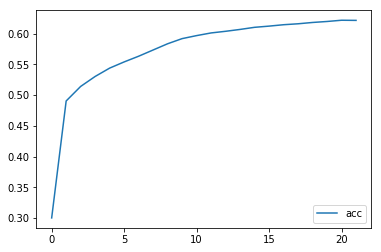

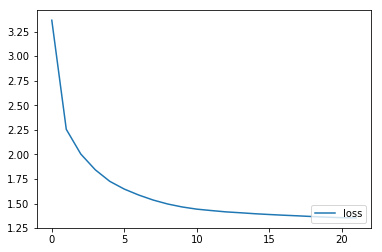

In [23]:
score = model.evaluate(train_data, combats_train_hot_label, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
plt.plot(record.history['acc'],label='acc')
#plt.plot(record.history['val_acc'],label='val_acc')
plt.legend(loc='lower right')
plt.show()
plt.plot(record.history['loss'],label='loss')
#plt.plot(record.history['val_loss'],label='val_loss')
plt.legend(loc='lower right')
plt.show()

# Testing

## Read testing data

## Predict results

In [11]:
###### use "model.predict(testing_data)" to get the results ######
from keras.models import load_model

#model = load_model('bridge_model_80000_LSTM.h5')

pred = np.argmax(model.predict(test_data), axis=1).reshape(20000,1)
pred_array = model.predict(test_data)
print(pred_array)
#while(True):



#avoid invalid move

for i in range(20000):
    check = True
    while(check):
        check = False
        for j in range(int(avoid_data[i][16])-1):
            if(pred[i]>=1 and pred[i]<=35):
                if(avoid_data[i][j]>pred[i] and avoid_data[i][j]>=1 and avoid_data[i][j]<=35):
                    pred_array[i][pred[i]] = 0
                    pred[i] = np.argmax(pred_array[i])
                    check = True
            else:
                if(avoid_data[i][j]>pred[i] and (avoid_data[i][j]==36 or avoid_data[i][j]==37)):
                    pred_array[i][pred[i]] = 0
                    pred[i] = np.argmax(pred_array[i])
                    check = True

predicted_output_df = pd.DataFrame(pred, columns = ["card output"])  #predicted output
output = pd.read_csv('bridge_test_output2.csv') #real ouput

count = 0
for i in range(20000):
    if(predicted_output_df.iloc[i][0]==output.iloc[i][0]):
        count+=1

print(count/20000)#the test accuracy
print(count)




NameError: name 'test_data' is not defined

In [ ]:


output = np.asarray(output)
test_data = np.asarray(test_data)
predicted_output_df = np.asarray(predicted_output_df)

temp = [[0 for x in range(38)] for y in range(20000)]

for i in range(len(output)):
    temp[i][int(output[i])] = 1



score= model.evaluate(test_data, temp, verbose=0)

## Print the result to csv file

In [ ]:
df.to_csv('result.csv',index_label = "index")

In [16]:
df = pd.read_csv('bridge_test.csv') 
test_df = df


print(len(test_df.iloc[:,:]))
print(test_df.iloc[:,:].shape)
#print(test_df)

test_data=[]

for i in range(len(test_df.iloc[:,:])):
    if test_df.iloc[i,1] == 'none':
        test_df.iloc[i,1] = 0
    elif test_df.iloc[i,1] == 'NS':
        test_df.iloc[i,1] = 1
    elif test_df.iloc[i,1] == 'EW':
        test_df.iloc[i,1] = 2
    elif test_df.iloc[i,1] == 'both':
        test_df.iloc[i,1] = 3
    split_list = test_df.iloc[i,4].split('|')
    temp = 0
    temp_list_bidding =[-1]*12
    for j in range(len(split_list)):
        if(j>11):
            break;
        split_list[j] = split_list[j].replace("!", "")
        if(split_list[j][0]=='p' or split_list[j][0]=='P'):
            temp_list_bidding[j]=0
            continue
        if(split_list[j][0]=='d' or split_list[j][0]=='D'):
            temp_list_bidding[j]=36
            continue
        if(split_list[j][0]=='r' or split_list[j][0]=='R'):
            temp_list_bidding[j]=37
            continue
                
                
        temp = 0
        if(len(split_list[j]) != 2):
            temp = -1
            break
        if(split_list[j][0].isdigit()):
            temp += (int(split_list[j][0])-1)*5
        if(split_list[j][1] == 'C' or split_list[j][1] == 'c'):
            temp += 1
        elif(split_list[j][1] == 'D' or split_list[j][1] == 'd' ):
            temp += 2
        elif(split_list[j][1] == 'H' or split_list[j][1] == 'h'):
            temp += 3
        elif(split_list[j][1] == 'S' or split_list[j][1] == 's'):
            temp += 4
        elif(split_list[j][1] == 'N' or split_list[j][1] == 'n'):
            temp += 5
        else:
            temp = -1
            break
        temp_list_bidding[j] = temp
        
    temp_list = []
    temp_list.append(test_df.iloc[i,0])
    temp_list.append(test_df.iloc[i,1])
    temp_list.append(test_df.iloc[i,2])
    temp_list.append(test_df.iloc[i,3])
    for j in range(12):
        temp_list.append(temp_list_bidding[j])
    temp_list.append(test_df.iloc[i,5])

    split_list6 = test_df.iloc[i,6].split('|')
    for j in range(4):
        temp_list.append(split_list6[j])
    '''
    split_list7 = test_df.iloc[i,7].split('|')
    for j in range(4):
        temp_list.append(split_list7[j])
    '''
    split_list9 = test_df.iloc[i,9].split('|')    
    for j in range(4):
        suit = [0]*13
        for k in range(len(split_list9[j])):
            if split_list9[j][k] == 'A':
                suit[1] = 1
            elif split_list9[j][k] == 'K':
                suit[0] = 1
            elif split_list9[j][k] == 'Q':
                suit[12] = 1
            elif split_list9[j][k] == 'J':
                suit[11] = 1
            elif split_list9[j][k] == 'T':
                suit[10] = 1
            elif split_list9[j][k].isdigit():
                suit[int(split_list9[j][k])] = 1
            else:
                suit[k] = -1
        temp_list = temp_list + suit
        
    split_list10 = test_df.iloc[i,10].split('|')
    for j in range(4):
        temp_list.append(split_list10[j])
    temp_list.append(test_df.iloc[i,11])
    
    split_list12 = test_df.iloc[i,12].split('|')
    for j in range(4):
        temp_list.append(split_list12[j])
    split_list13 = test_df.iloc[i,13].split('|')
    for j in range(4):
        temp_list.append(split_list13[j])
    split_list14 = test_df.iloc[i,14].split('|')
    for j in range(4):
        temp_list.append(split_list14[j])
    split_list15 = test_df.iloc[i,15].split('|')
    for j in range(4):
        temp_list.append(split_list15[j])
    
    temp_list.append(test_df.iloc[i,16])
    temp_list.append(test_df.iloc[i,17])
    if(test_df.iloc[i,18] == 'N'):
        temp_list.append(0)
    elif(test_df.iloc[i,18] == 'S'):
        temp_list.append(1)
    elif(test_df.iloc[i,18] == 'E'):
        temp_list.append(2)
    elif(test_df.iloc[i,18] == 'W'):
        temp_list.append(3)
    else:
        temp_list.append(-1)
        
    
    test_data.append(temp_list)

test_data = np.asarray(test_data)
test_data = test_data.astype('float')
print(test_data[0])
print(test_data[999])
print(test_data)
print(test_data.shape)

avoid_data = test_data


test_data = preprocessing.scale(test_data)
'''
test_data[:,0] = test_data[:,0]/50
test_data[:,1] = test_data[:,1]/3
test_data[:,4:15] = test_data[:,4:15]/37
test_data[:,16] = test_data[:,16]/4
test_data[:,17:20] = test_data[:,17:20]/13
test_data[:,73:76] = test_data[:,73:76]/13
test_data[:,81] = test_data[:,81]/30
test_data[:,91:94] = test_data[:,91:94]/10
test_data[:,95] = test_data[:,95]/10
test_data[:,96] = test_data[:,96]/10
'''

print(test_data.shape)
print(type(test_data))
print(test_data[0,:])
print(test_data)


20000
(20000, 19)


KeyboardInterrupt: 

In [ ]:
import csv
bridge_df_test = []

bridge_df_test = pd.concat([bridge_dfN_test, bridge_dfS_test], ignore_index=True)
bridge_df_test = pd.concat([bridge_df_test, bridge_dfE_test], ignore_index=True)
bridge_df_test = pd.concat([bridge_df_test, bridge_dfW_test], ignore_index=True)

bridge_df_test.to_csv("bridge_test.csv", encoding='utf-8', index=False)
